In [1]:
library(variableStars)
library(data.table)
library(ggplot2)
library(RColorBrewer)
library(plotly)
library(keras)
library(plotly)
library(abind)
library(fields)


Attaching package: 'plotly'

The following object is masked from 'package:ggplot2':

    last_plot

The following object is masked from 'package:stats':

    filter

The following object is masked from 'package:graphics':

    layout

Loading required package: spam
Loading required package: dotCall64
Loading required package: grid
Spam version 2.2-0 (2018-06-19) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.

Attaching package: 'spam'

The following objects are masked from 'package:base':

    backsolve, forwardsolve

Loading required package: maps
See www.image.ucar.edu/~nychka/Fields for
 a vignette and other supplements. 


### Read processed files and create big matrix with all rows

In [2]:
setwd("~/Downloads/")
df_all <- NA
for (file in list.files(pattern = "*log")) {
    print(file)
    if (is.null(df_all)) {
        df_all <- data.frame(read.csv(file, sep=",", header = F))
    } else {
        df_all <- rbind(df_all, data.frame(read.csv(file, sep=",", header = F)))
    }
}

[1] "data0.log"
[1] "data1.log"
[1] "data2.log"
[1] "data3.log"
[1] "data4.log"
[1] "data5.log"
[1] "data6.log"
[1] "data7.log"
[1] "data8.log"
[1] "data9.log"


In [3]:
dim(df_all)

[1] 92873   614

### Experiment parameters

In [4]:
# Resolution for target frequency [0-100]
input_resolution <- 0.5
output_resolution <- 1.0

# Input dimension
cuts_breaks <- c(-Inf, seq(0, 101, input_resolution), Inf)
input_dim <- length(cuts_breaks) - 1

# Output dimension
num_classes <-
  length(seq(
    from = 0.1,
    to = 14 / 0.0864,
    by = output_resolution
  )) # Buckets of possible classes

### Matrix creation from data

In [5]:
rows <- dim(df_all)[1]
cols <- (dim(df_all)[2] - 2) / 3
dimensions <- 3 # Number of channels
X <- array(0, c(rows, cols, dimensions))
# Y train is a 1D matrix with rows and targets
Y <- matrix(nrow = rows, ncol = num_classes)

In [6]:
# Loop over data and insert into matrix dimensions
for (i in seq(from=2,to=(rows-1))) {
  X[i, , 1] <- as.numeric(df_all[i, 1:204])
  X[i, , 2] <- as.numeric(df_all[i, 204:((204 * 2) - 1)])
  X[i, , 3] <- as.numeric(df_all[i, (204 * 2):((204 * 3) - 1)])
  
  #Y[i, ] <- to_categorical(d[i,613:613], num_classes)
  Y[i,] <- to_categorical(df_all[i, 614:614], num_classes)
}
dim(X)
dim(Y)

[1] 92873   204     3

[1] 92873   162

In [7]:
# Split train/test
smp_size <- floor(0.75 * nrow(X))
set.seed(123)
ind <- sample(seq_len(nrow(X)), size = smp_size)

# Prepare partition
x_train <- X[ind, , ]
x_test  <- X[-ind, , ]
y_train <- Y[ind, ]
y_test  <- Y[-ind, ]
# Check dims
dim(x_train)
dim(y_train)
dim(x_test)
dim(y_test)

[1] 69654   204     3

[1] 69654   162

[1] 23219   204     3

[1] 23219   162

### NN train

In [ ]:
top_12_categorical_accuracy <-
  custom_metric("rec_at_12", function(y_true, y_pred) {
    metric_top_k_categorical_accuracy(y_true, y_pred, 12)
  })
top_6_categorical_accuracy <-
  custom_metric("recat_6", function(y_true, y_pred) {
    metric_top_k_categorical_accuracy(y_true, y_pred, 6)
  })
top_4_categorical_accuracy <-
  custom_metric("rec_at_4", function(y_true, y_pred) {
    metric_top_k_categorical_accuracy(y_true, y_pred, 4)
  })
top_2_categorical_accuracy <-
  custom_metric("rec_at_2", function(y_true, y_pred) {
    metric_top_k_categorical_accuracy(y_true, y_pred, 2)
  })


# Create a 1d convolutional NN
model <- keras_model_sequential() %>%
  layer_separable_conv_1d(
    kernel_size = 10,
    filters = 8,
    depth_multiplier = 10,
    input_shape = c(204, 3)
  ) %>%
  layer_max_pooling_1d(pool_size = 2) %>%
  layer_dropout(0.2) %>%
  layer_batch_normalization() %>%
  
  layer_separable_conv_1d(
    kernel_size = 10,
    filters = 7,
    depth_multiplier = 10,
    input_shape = c(204, 3)
  ) %>%
  layer_max_pooling_1d(pool_size = 2) %>%
  layer_dropout(0.2) %>%
  layer_batch_normalization() %>%

  layer_separable_conv_1d(
    kernel_size = 10,
    filters = 7,
    depth_multiplier = 10,
    input_shape = c(204, 3)
  ) %>%
  layer_max_pooling_1d(pool_size = 2) %>%
  layer_dropout(0.2) %>%
  layer_batch_normalization() %>%

  
  layer_flatten() %>%
  layer_dense(units = num_classes, activation = 'softmax')



# Configure a model for categorical classification.
model %>% compile(
  loss = "categorical_crossentropy",
  optimizer = optimizer_adadelta(lr = 0.01),
  metrics = c(
          "accuracy",
          top_2_categorical_accuracy,
          top_4_categorical_accuracy,
          top_6_categorical_accuracy
        )
)
summary(model) # Plot summary

# Fit model
  history <- model %>% fit(
    x_train,
    y_train,
    epochs = 2000,
    batch_size =  250,
    validation_split = 0.2,
    shuffle = T,
    verbose = 2
  )

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
separable_conv1d_4 (SeparableConv1D (None, 195, 8)                  548         
________________________________________________________________________________
max_pooling1d_4 (MaxPooling1D)      (None, 97, 8)                   0           
________________________________________________________________________________
dropout_4 (Dropout)                 (None, 97, 8)                   0           
________________________________________________________________________________
batch_normalization_4 (BatchNormali (None, 97, 8)                   32          
________________________________________________________________________________
separable_conv1d_5 (SeparableConv1D (None, 88, 7)                   1367        
________________________________________________________________________________
max_pooling1d_5 (MaxPooling1

In [9]:
evaluate(model, x_test, y_test)

$loss
[1] NaN

$acc
[1] 0.2404066

$rec_at_2
[1] 0.4109565

$rec_at_4
[1] 0.6103191

$recat_6
[1] 0.7157931

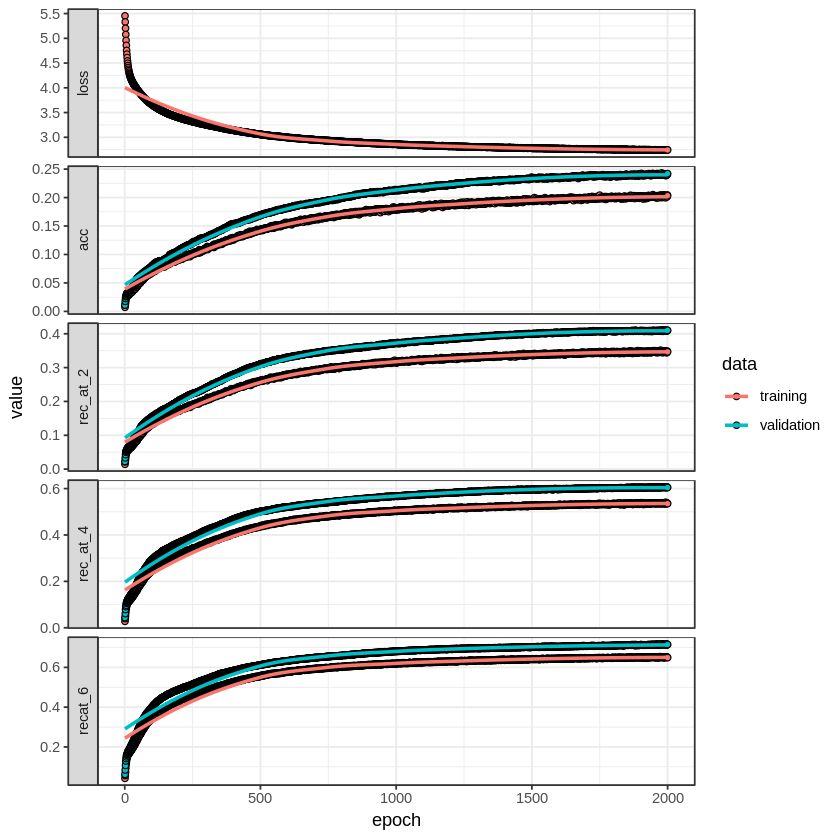

In [10]:
plot(history) +
  theme_bw()

### Confusion matrix

In [28]:
Y_test_hat <- predict_classes(model, x_test)
# Calculate confusion matrix
cm <- table(apply(y_test,1,which.max), Y_test_hat)

# Plot matrix
dtCM <- as.data.frame(cm)
colnames(dtCM) <- c("c1","c2","freq")
ggplot(data=dtCM, aes(c1, c2, fill = freq)) +
  geom_raster() +
  scale_fill_gradientn(colours=c("#0000FFFF","#FFFFFFFF","#FF0000FF"))

ERROR: Error in order(y): unimplemented type 'list' in 'orderVector1'

